# Exercise 3: 

_Learn to clip a satellite image to AOI and reproject into a new CRS_


In [1]:
import rasterio
from matplotlib import pyplot as plt

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
image_file = "example.tif"

# Use Rasterio to open the image.
satdat = rasterio.open(image_file)

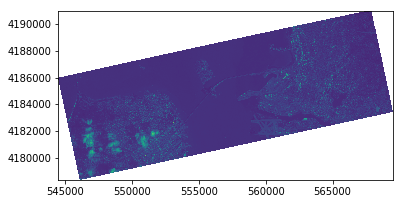

In [3]:
# rasterio.plot.show is a shortcut to matplotlib plotting

from rasterio.plot import show
show(satdat)

In [19]:
# check the metadata - note the CRS: EPSG 32610, or WGS 84 / UTM zone 10N
satdat.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 8341,
 'height': 4213,
 'count': 4,
 'crs': CRS.from_dict(init='epsg:32610'),
 'transform': Affine(3.0, 0.0, 544491.0,
        0.0, -3.0, 4191009.0)}

In [5]:
# use rasterio's sister-library for working with vector data
import fiona

# use fiona to open our AOI GeoJSON
with fiona.open('aoi.geojson') as f:
    aoi = [feature["geometry"] for feature in f]

In [6]:
# import rasterio's mask tool
from rasterio.mask import mask

# apply mask with crop=True to cut to boundary
with rasterio.open('example.tif') as img:
    clipped, transform = mask(img, aoi, crop=True)
    
# save the output to a final GeoTIFF

# use the metadata from our original mosaic
meta = img.meta.copy()

# update metadata with new, clipped mosaic's boundaries
meta.update({"transform": transform,
    "height":clipped.shape[1],
    "width":clipped.shape[2]})

# write the output to a GeoTIFF
with rasterio.open('clipped.tif', 'w', **meta) as dst:
    dst.write(clipped)


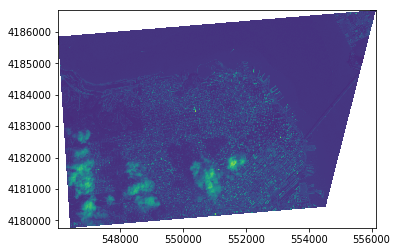

In [8]:
clipped = rasterio.open("clipped.tif")
show(clipped)

### Reprojecting with rasterio

Now let's reproject our clipped dataset: for this example, we'll reproject into EPSG 4326

In [20]:
from rasterio.warp import calculate_default_transform, reproject

# define our target CRS - rasterio will accept any CRS that can be defined using WKT
target_crs = 'EPSG:4326'

# calculate a transform and new dimensions using our dataset's current CRS and dimensions
transform, width, height = calculate_default_transform(clipped.crs, 
                                                       target_crs, 
                                                       clipped.width, 
                                                       clipped.height, 
                                                       *clipped.bounds)

# Copy the metadata from our original dataset
metadata = clipped.meta.copy()

# Change the CRS, transform, and dimensions in metadata to match our desired output dataset
metadata.update({'crs':target_crs, 
                'transform':transform,
                'width':width,
                'height':height})

In [24]:
# at this point we have calculated the transform required to reproject our dataset from EPSG:32610 to EPSG:4326
# and defined new metadata based on the source dataset's current metadata

# apply the transform & metadata to perform the reprojection
# here we're saving the output to a new 'clipped_4326.tif' file
with rasterio.open('clipped_4326.tif', 'w', **metadata) as reprojected:
    for band in range(1, clipped.count + 1):
        reproject(
            source=rasterio.band(clipped, band),
            destination=rasterio.band(reprojected, band),
            src_transform=clipped.transform,
            src_crs=clipped.crs,
            dst_transform=transform,
            dst_crs=target_crs
        )

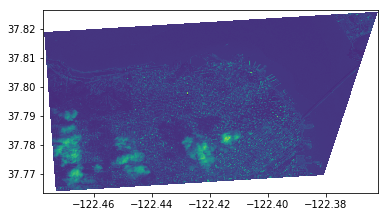

In [23]:
# take a look at our clipped & reprojected dataset
reproj = rasterio.open("clipped_4326.tif")
show(reproj)